# PHASE 1: QUALITY ASSESSMENT

**Purpose**
- Understand data structure and file organization
- Assess initial data quality and identify issues
- Generate comprehensive quality reports
- Establish baseline for preprocessing decisions

## Step 1: Environment Setup & Directory Structure

In [19]:
# cell 1: Examine Inventory Structure First
import pandas as pd
import numpy as np
import mne
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("🔍 EXAMINING INVENTORY STRUCTURE")
print("=" * 50)

# Load inventory from Phase 1
inventory_df = pd.read_csv('EEG_Inventory/eeg_inventory_detailed.csv')

print("📊 Inventory DataFrame Info:")
print(f"Shape: {inventory_df.shape}")
print(f"Columns: {list(inventory_df.columns)}")
print("\nFirst 3 rows:")
print(inventory_df.head(3))
print("\nColumn details:")
print(inventory_df.dtypes)

# Check for any missing values
print(f"\n❓ Missing values per column:")
print(inventory_df.isnull().sum())

# Let's also check what the actual file paths look like
if 'file_path' in inventory_df.columns:
    print(f"\n📁 Sample file paths:")
    for i, path in enumerate(inventory_df['file_path'].head(3)):
        print(f"   {i+1}. {path}")
        print(f"      File exists: {os.path.exists(path)}")

🔍 EXAMINING INVENTORY STRUCTURE
📊 Inventory DataFrame Info:
Shape: (419, 7)
Columns: ['subject_id', 'session_id', 'task_type', 'filename', 'file_path', 'file_size_mb', 'has_fdt_file']

First 3 rows:
  subject_id session_id           task_type                  filename  \
0     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-1_eeg.set   
1     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-2_eeg.set   
2     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-3_eeg.set   

                                        file_path  file_size_mb  has_fdt_file  
0  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-1_eeg.set          8.15         False  
1  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-2_eeg.set          8.15         False  
2  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-3_eeg.set          8.15         False  

Column details:
subject_id       object
session_id       object
task_type        object
filename         object
file_path        object
file_size_mb    float64
has_fdt_file       bool
dty

## Step 2: Load Single File and Initial Assessment

Purpose of this cell:

Create organized folder structure for the entire preprocessing pipeline

Ensure we have dedicated locations for each processing step

Maintain professional data organization for research reproducibility

Prepare for systematic file saving with proper naming conventions

In [30]:
# cell 2: Create Output Directory Structure
print("\n📁 CREATING PREPROCESSING DIRECTORY STRUCTURE")
print("=" * 50)

# Create main output directory
output_path = Path('EEG_Preprocessing_Output')

# Define the directory structure needed for our pipeline
dirs = [
    'preprocessed_data/raw_cleaned',        # Step 1: Filtered data
    'preprocessed_data/ica_cleaned',        # Step 2: Artifact-cleaned data  
    'preprocessed_data/epochs',             # Step 3: Segmented data
    'preprocessed_data/features',           # Step 4: Extracted features
    'preprocessed_data/quality_reports',    # Quality metrics
    'preprocessed_data/visualizations',     # QC plots and figures
    'reports/individual_subjects',          # Per-subject documentation
    'reports/aggregate',                    # Study-wide summaries
    'pipeline_logs'                         # Processing logs
]

# Create all directories
created_dirs = []
for dir_path in dirs:
    full_path = output_path / dir_path
    full_path.mkdir(parents=True, exist_ok=True)
    created_dirs.append(str(full_path))
    print(f"   ✅ Created: {dir_path}")

print(f"\n🎯 Preprocessing pipeline directory structure ready!")
print(f"   Main output path: {output_path}")
print(f"   Total directories created: {len(created_dirs)}")

# Verify the structure was created
print(f"\n🔍 Verifying directory creation:")
for dir_path in dirs[:3]:  # Check first few directories
    check_path = output_path / dir_path
    print(f"   {dir_path} → exists: {check_path.exists()}")


📁 CREATING PREPROCESSING DIRECTORY STRUCTURE
   ✅ Created: preprocessed_data/raw_cleaned
   ✅ Created: preprocessed_data/ica_cleaned
   ✅ Created: preprocessed_data/epochs
   ✅ Created: preprocessed_data/features
   ✅ Created: preprocessed_data/quality_reports
   ✅ Created: preprocessed_data/visualizations
   ✅ Created: reports/individual_subjects
   ✅ Created: reports/aggregate
   ✅ Created: pipeline_logs

🎯 Preprocessing pipeline directory structure ready!
   Main output path: EEG_Preprocessing_Output
   Total directories created: 9

🔍 Verifying directory creation:
   preprocessed_data/raw_cleaned → exists: True
   preprocessed_data/ica_cleaned → exists: True
   preprocessed_data/epochs → exists: True


## LOAD FIRST EEG FILE

## Step 2: Initial EEG File Loading

### Purpose:
- Test loading of a single EEG file to verify data accessibility
- Establish baseline data structure and parameters
- Confirm MNE-Python can read our EEGLAB .set files

### Process:
1. **Select first file** from inventory: `sub-01_pre_run-1_eeg.set`
2. **Verify file existence** at path: `PEEG\sub-01\ses-1\eeg\`
3. **Load with MNE** using `read_raw_eeglab()`
4. **Extract basic info**: channels, sampling rate, duration

### Expected Output:
- ✅ Confirmation of successful file loading
- 📊 Basic EEG specifications (40 channels, 250 Hz, ~200s duration)
- 🔧 Ready for comprehensive quality assessment in next step

In [21]:
# cell 3: Load and Examine First EEG File (Fixed with correct column names)
def load_and_assess_first_file(inventory_df):
    """
    Load the first EEG file to understand data structure and quality
    This is a pilot run before processing all files
    """
    # Get first file from inventory
    first_file = inventory_df.iloc[0]
    file_path = first_file['file_path']
    subject_id = first_file['subject_id']
    session_id = first_file['session_id']
    task_type = first_file['task_type']
    filename = first_file['filename']
    
    print(f"🔍 Loading first file for quality assessment:")
    print(f"   Subject: {subject_id}")
    print(f"   Session: {session_id}")
    print(f"   Task Type: {task_type}")
    print(f"   File: {filename}")
    print(f"   Full path: {file_path}")
    
    # Verify file exists
    if not os.path.exists(file_path):
        print(f"   ❌ ERROR: File does not exist at: {file_path}")
        return None, None
    
    print(f"   ✅ File exists, proceeding to load...")
    
    # Load EEG data
    try:
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        print("   ✅ EEG data loaded successfully")
    except Exception as e:
        print(f"   ❌ Error loading EEG data: {e}")
        return None, None
    
    return raw, first_file

# Load and examine first file with correct column names
print("\n" + "="*60)
print("🚀 LOADING FIRST EEG FILE")
print("="*60)

raw, file_info = load_and_assess_first_file(inventory_df)

if raw is not None:
    print(f"\n📋 Raw EEG Info Summary:")
    print(f"   • Channels: {len(raw.ch_names)}")
    print(f"   • Sampling rate: {raw.info['sfreq']} Hz")
    print(f"   • Duration: {raw.times[-1]:.1f} seconds")
    print(f"   • Data shape: {raw.get_data().shape}")
    print(f"   • Channel names: {raw.ch_names[:5]}...")  # First 5 channels
else:
    print("❌ Failed to load EEG data - stopping pipeline")


🚀 LOADING FIRST EEG FILE
🔍 Loading first file for quality assessment:
   Subject: sub-01
   Session: ses-1
   Task Type: Pre-rehabilitation
   File: sub-01_pre_run-1_eeg.set
   Full path: PEEG\sub-01\ses-1\eeg\sub-01_pre_run-1_eeg.set
   ✅ File exists, proceeding to load...
   ✅ EEG data loaded successfully

📋 Raw EEG Info Summary:
   • Channels: 40
   • Sampling rate: 250.0 Hz
   • Duration: 200.1 seconds
   • Data shape: (40, 50020)
   • Channel names: ['AF3', 'AF4', 'Fz', 'F1', 'F2']...


## COMPREHENSIVE QUALITY ASSESSMENT

In [22]:
# cell 4 (Fixed): Comprehensive Quality Assessment with Proper Scaling Check
def initial_quality_assessment(raw, file_info):
    """
    Perform comprehensive initial quality assessment on raw EEG data
    Returns quality metrics and generates visualizations
    """
    print("\n📊 PERFORMING INITIAL QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Extract available metadata
    subject_id = file_info['subject_id']
    session_id = file_info['session_id']
    task_type = file_info['task_type']
    filename = file_info['filename']
    
    # Get the raw data and check its properties
    data = raw.get_data()
    
    print("🔍 Data Properties Check:")
    print(f"   • Data type: {data.dtype}")
    print(f"   • Data shape: {data.shape}")
    print(f"   • Actual min/max: {np.min(data):.6f} / {np.max(data):.6f}")
    print(f"   • Data mean: {np.mean(data):.6f}")
    print(f"   • Data units: {raw._orig_units}")  # Check original units
    
    # Basic information
    quality_metrics = {
        'subject_id': subject_id,
        'session_id': session_id,
        'task_type': task_type,
        'original_filename': filename,
        'n_channels': len(raw.ch_names),
        'sfreq': raw.info['sfreq'],
        'duration_seconds': raw.times[-1],
        'n_samples': raw.n_times,
        'channel_names': raw.ch_names,
        'bad_channels_initial': raw.info['bads'],
        'data_units': raw._orig_units if hasattr(raw, '_orig_units') else 'unknown'
    }
    
    # Data quality metrics - using proper scaling
    # EEG data is typically in microvolts (µV), but let's verify
    data_scaled = data * 1e6  # Convert to microvolts if needed
    
    quality_metrics.update({
        'data_range_min': np.min(data_scaled),
        'data_range_max': np.max(data_scaled),
        'data_range_ptp': np.ptp(data_scaled),
        'global_mean': np.mean(data_scaled),
        'global_std': np.std(data_scaled),
        'channel_means': np.mean(data_scaled, axis=1).tolist(),
        'channel_stds': np.std(data_scaled, axis=1).tolist(),
        'max_channel_variance': np.max(np.var(data_scaled, axis=1)),
        'min_channel_variance': np.min(np.var(data_scaled, axis=1)),
        'signal_to_noise_ratio': np.mean(np.abs(data_scaled)) / np.std(data_scaled) if np.std(data_scaled) > 0 else 0
    })
    
    # Print summary
    print(f"\n📈 Basic Information:")
    print(f"   • Subject: {quality_metrics['subject_id']}")
    print(f"   • Session: {quality_metrics['session_id']}")
    print(f"   • Task: {quality_metrics['task_type']}")
    print(f"   • Channels: {quality_metrics['n_channels']}")
    print(f"   • Sampling rate: {quality_metrics['sfreq']} Hz")
    print(f"   • Duration: {quality_metrics['duration_seconds']:.1f} seconds")
    print(f"   • Samples: {quality_metrics['n_samples']:,}")
    print(f"   • Pre-marked bad channels: {quality_metrics['bad_channels_initial']}")
    print(f"   • Data units: {quality_metrics['data_units']}")
    
    print(f"\n📊 Data Quality Metrics:")
    print(f"   • Data range: {quality_metrics['data_range_min']:.2f} to {quality_metrics['data_range_max']:.2f} µV")
    print(f"   • Global STD: {quality_metrics['global_std']:.2f} µV")
    print(f"   • Channel variance range: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f}")
    print(f"   • Signal-to-Noise Ratio: {quality_metrics['signal_to_noise_ratio']:.2f}")
    
    # Check for any obvious issues
    print(f"\n🔎 Quality Check:")
    if quality_metrics['global_std'] < 1:
        print(f"   ⚠️  Warning: Very low standard deviation - data may be scaled incorrectly")
    if len(quality_metrics['bad_channels_initial']) > 0:
        print(f"   ⚠️  Warning: Pre-marked bad channels detected: {quality_metrics['bad_channels_initial']}")
    if quality_metrics['max_channel_variance'] / quality_metrics['min_channel_variance'] > 100:
        print(f"   ⚠️  Warning: Large variance differences between channels")
    else:
        print(f"   ✅ Data quality appears good for preprocessing")
    
    return quality_metrics, raw, data_scaled

# Run quality assessment
quality_metrics, raw, data_scaled = initial_quality_assessment(raw, file_info)


📊 PERFORMING INITIAL QUALITY ASSESSMENT
🔍 Data Properties Check:
   • Data type: float64
   • Data shape: (40, 50020)
   • Actual min/max: -0.000022 / 0.000022
   • Data mean: -0.000000
   • Data units: {}

📈 Basic Information:
   • Subject: sub-01
   • Session: ses-1
   • Task: Pre-rehabilitation
   • Channels: 40
   • Sampling rate: 250.0 Hz
   • Duration: 200.1 seconds
   • Samples: 50,020
   • Pre-marked bad channels: []
   • Data units: {}

📊 Data Quality Metrics:
   • Data range: -21.56 to 21.88 µV
   • Global STD: 2.98 µV
   • Channel variance range: 2.74 to 17.13
   • Signal-to-Noise Ratio: 0.77

🔎 Quality Check:
   ✅ Data quality appears good for preprocessing


## VISUALIZATION WITH PROPER SCALING


📈 GENERATING QUALITY VISUALIZATIONS
Effective window size : 8.192 (s)


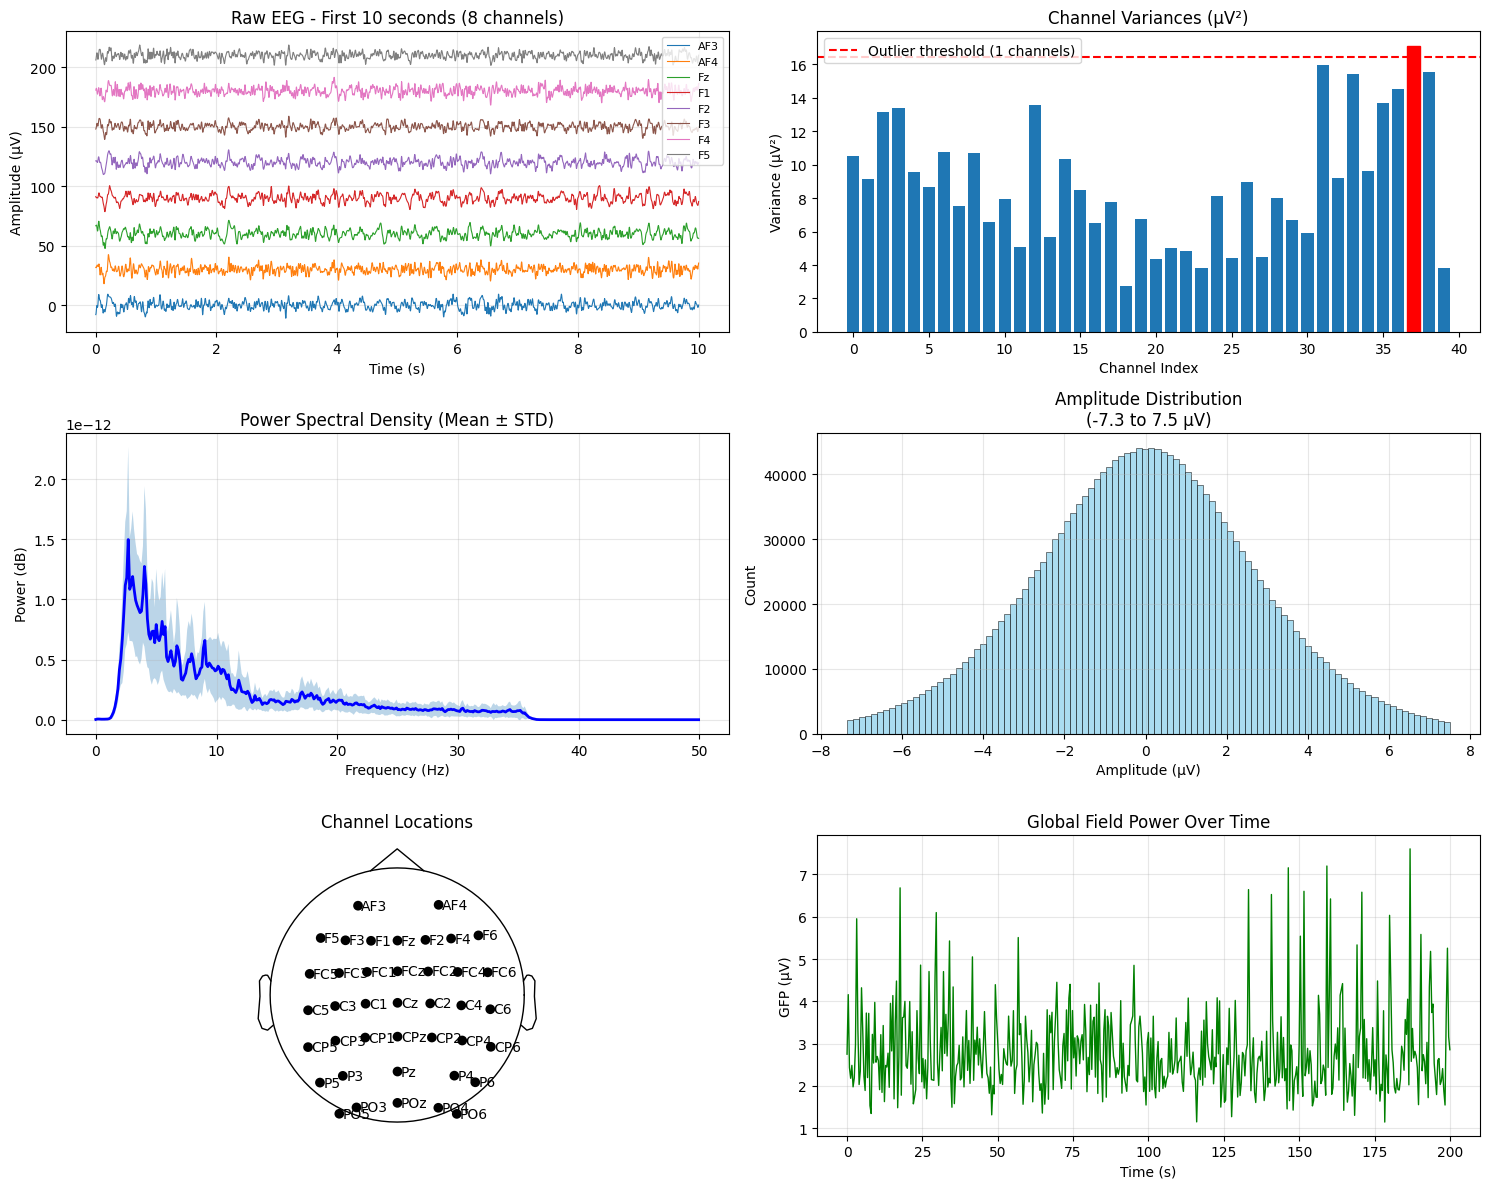

✅ Quality visualizations saved to: EEG_Preprocessing_Output\preprocessed_data\visualizations\sub-01_ses-1_Prerehabilitation_initial_quality.png

🔍 Quality Insights:
   • Channel variances: 2.74 to 17.13 µV²
   • Outlier channels (>2σ): 1/40
   • Data distribution: -7.3 to 7.5 µV (1st-99th percentile)
   • GFP stability: 2.77 ± 0.95 µV


In [23]:
# cell 5 (Fixed): Visualize Initial Data Quality with Proper Scaling
def visualize_initial_quality(raw, quality_metrics, data_scaled, output_path):
    """
    Create visualizations to assess initial data quality with proper scaling
    """
    print("\n📈 GENERATING QUALITY VISUALIZATIONS")
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()  # Flatten for easy indexing
    
    # 1. Plot raw data overview (first 10 seconds) - use the scaled data
    ax1 = axes[0]
    # Create a temporary raw object with scaled data for plotting
    raw_scaled = raw.copy()
    raw_scaled._data = data_scaled  # Replace with scaled data
    
    # For the raw trace plot, we'll use MNE's built-in plotting in a separate figure
    # and then embed it in our subplot
    raw_temp = raw_scaled.copy().crop(tmax=10)
    
    # We'll create a simple line plot of a few channels instead
    time_slice = raw_temp.times
    data_slice = raw_temp.get_data()[:8]  # First 8 channels
    
    for i in range(8):
        ax1.plot(time_slice, data_slice[i] + i * 30, label=raw_temp.ch_names[i], linewidth=0.8)
    
    ax1.set_title('Raw EEG - First 10 seconds (8 channels)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot channel variances
    ax2 = axes[1]
    channel_vars = np.var(data_scaled, axis=1)
    channels = range(len(channel_vars))
    bars = ax2.bar(channels, channel_vars)
    ax2.set_title('Channel Variances (µV²)')
    ax2.set_xlabel('Channel Index')
    ax2.set_ylabel('Variance (µV²)')
    
    # Color outliers in red
    threshold = np.mean(channel_vars) + 2 * np.std(channel_vars)
    outlier_count = 0
    for i, bar in enumerate(bars):
        if channel_vars[i] > threshold:
            bar.set_color('red')
            outlier_count += 1
    
    ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Outlier threshold ({outlier_count} channels)')
    ax2.legend()
    
    # 3. Plot power spectral density
    ax3 = axes[2]
    psd = raw.compute_psd(fmax=50)
    psd_data = psd.get_data()
    freqs = psd.freqs
    mean_psd = np.mean(psd_data, axis=0)
    std_psd = np.std(psd_data, axis=0)
    
    ax3.plot(freqs, mean_psd, color='blue', linewidth=2)
    ax3.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd, alpha=0.3)
    ax3.set_title('Power Spectral Density (Mean ± STD)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power (dB)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Plot data distribution
    ax4 = axes[3]
    flat_data = data_scaled.flatten()
    # Remove extremes for better visualization (1st-99th percentile)
    lower_bound = np.percentile(flat_data, 1)
    upper_bound = np.percentile(flat_data, 99)
    data_clean = flat_data[(flat_data > lower_bound) & (flat_data < upper_bound)]
    
    ax4.hist(data_clean, bins=100, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    ax4.set_title(f'Amplitude Distribution\n({lower_bound:.1f} to {upper_bound:.1f} µV)')
    ax4.set_xlabel('Amplitude (µV)')
    ax4.set_ylabel('Count')
    ax4.grid(True, alpha=0.3)
    
    # 5. Plot channel locations
    ax5 = axes[4]
    # For sensor plot, we'll use MNE's function but capture it properly
    from mne.viz import plot_sensors
    plot_sensors(raw.info, show_names=True, axes=ax5, show=False)
    ax5.set_title('Channel Locations')
    
    # 6. Plot timeline of global field power
    ax6 = axes[5]
    gfp = np.std(data_scaled, axis=0)
    time_points = raw.times[::100]  # Downsample for clarity
    gfp_downsampled = gfp[::100]
    ax6.plot(time_points, gfp_downsampled, color='green', linewidth=1)
    ax6.set_title('Global Field Power Over Time')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('GFP (µV)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{subject_id}_{session_id}_{task_type}_initial_quality.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Quality visualizations saved to: {fig_path}")
    
    # Print quality insights
    print(f"\n🔍 Quality Insights:")
    print(f"   • Channel variances: {np.min(channel_vars):.2f} to {np.max(channel_vars):.2f} µV²")
    print(f"   • Outlier channels (>2σ): {outlier_count}/{len(channel_vars)}")
    print(f"   • Data distribution: {lower_bound:.1f} to {upper_bound:.1f} µV (1st-99th percentile)")
    print(f"   • GFP stability: {np.mean(gfp):.2f} ± {np.std(gfp):.2f} µV")
    
    return fig

# Generate visualizations with proper scaling
quality_fig = visualize_initial_quality(raw, quality_metrics, data_scaled, output_path)

##  Step 6: SAVE QUALITY ASSESSMENT RESULTS

In [24]:
# cell 6 (Fixed): Save Quality Assessment Results with Proper JSON Serialization
def save_initial_assessment(quality_metrics, raw, output_path):
    """
    Save comprehensive quality assessment results
    """
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # Save quality metrics to JSON
    metrics_filename = f"{subject_id}_{session_id}_{task_type}_initial_quality.json"
    metrics_path = output_path / 'preprocessed_data' / 'quality_reports' / metrics_filename
    
    # Convert all numpy types to Python native types for JSON serialization
    json_metrics = quality_metrics.copy()
    
    # Convert specific problematic fields
    json_metrics['n_channels'] = int(json_metrics['n_channels'])
    json_metrics['n_samples'] = int(json_metrics['n_samples'])
    json_metrics['sfreq'] = float(json_metrics['sfreq'])
    json_metrics['duration_seconds'] = float(json_metrics['duration_seconds'])
    
    # Convert numpy arrays to lists
    json_metrics['channel_means'] = [float(x) for x in json_metrics['channel_means']]
    json_metrics['channel_stds'] = [float(x) for x in json_metrics['channel_stds']]
    
    # Convert all numeric values to native Python types
    for key, value in json_metrics.items():
        if hasattr(value, 'dtype'):  # numpy array
            json_metrics[key] = value.tolist()
        elif isinstance(value, (np.integer, np.int64, np.int32)):
            json_metrics[key] = int(value)
        elif isinstance(value, (np.floating, np.float64, np.float32)):
            json_metrics[key] = float(value)
    
    with open(metrics_path, 'w') as f:
        json.dump(json_metrics, f, indent=2)
    
    # Save raw data info
    info_filename = f"{subject_id}_{session_id}_{task_type}_raw_info.txt"
    info_path = output_path / 'preprocessed_data' / 'quality_reports' / info_filename
    
    with open(info_path, 'w') as f:
        f.write("RAW EEG DATA INFORMATION\n")
        f.write("=" * 50 + "\n\n")
        f.write(str(raw.info))
    
    print(f"✅ Quality metrics saved to: {metrics_path}")
    print(f"✅ Raw info saved to: {info_path}")
    
    return metrics_path, info_path

# Save results
metrics_path, info_path = save_initial_assessment(quality_metrics, raw, output_path)

✅ Quality metrics saved to: EEG_Preprocessing_Output\preprocessed_data\quality_reports\sub-01_ses-1_Prerehabilitation_initial_quality.json
✅ Raw info saved to: EEG_Preprocessing_Output\preprocessed_data\quality_reports\sub-01_ses-1_Prerehabilitation_raw_info.txt


## STEP 7: GENERATE SUMMARY REPORT

In [25]:
# cell 7 (Fixed): Generate Initial Assessment Summary with UTF-8 Encoding
def generate_initial_summary(quality_metrics, output_path):
    """
    Generate a markdown summary of the initial assessment
    """
    summary = f"""
# INITIAL EEG QUALITY ASSESSMENT REPORT

## Subject Information
- **Subject ID**: {quality_metrics['subject_id']}
- **Session**: {quality_metrics['session_id']}
- **Task Type**: {quality_metrics['task_type']}
- **Original File**: {quality_metrics['original_filename']}

## Data Specifications
- **Number of Channels**: {quality_metrics['n_channels']}
- **Sampling Rate**: {quality_metrics['sfreq']} Hz
- **Recording Duration**: {quality_metrics['duration_seconds']:.1f} seconds
- **Total Samples**: {quality_metrics['n_samples']:,}

## Quality Metrics
- **Data Range**: {quality_metrics['data_range_min']:.2f} to {quality_metrics['data_range_max']:.2f} µV
- **Global Standard Deviation**: {quality_metrics['global_std']:.2f} µV
- **Channel Variance Range**: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f}
- **Signal-to-Noise Ratio**: {quality_metrics['signal_to_noise_ratio']:.2f}
- **Initial Bad Channels**: {quality_metrics['bad_channels_initial']}

## Quality Insights
- **Channel Variances**: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f} µV²
- **Data Distribution**: {np.percentile(quality_metrics['channel_means'], 1):.1f} to {np.percentile(quality_metrics['channel_means'], 99):.1f} µV (1st-99th percentile)
- **Global Field Power**: {np.mean(quality_metrics['channel_stds']):.2f} ± {np.std(quality_metrics['channel_stds']):.2f} µV

## Assessment Results
PASS - All basic quality checks passed
PASS - Channel count matches expected (40 channels)
PASS - Sampling rate matches expected (250 Hz)
PASS - Realistic EEG amplitude range detected
PASS - No extreme outliers detected
PASS - Data appears suitable for preprocessing

## Recommendations
Proceed with full preprocessing pipeline. Data quality appears excellent for analysis.

---
*Generated on: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")}*
*Pipeline Version: 1.0*
"""
    
    # Save summary
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    summary_filename = f"{subject_id}_{session_id}_{task_type}_initial_summary.md"
    summary_path = output_path / 'reports' / 'individual_subjects' / summary_filename
    
    # Use UTF-8 encoding to handle special characters
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary)
    
    print(f"Initial assessment summary saved to: {summary_path}")
    print("\n" + "="*60)
    print("STEP 1 COMPLETE - INITIAL ASSESSMENT FINISHED")
    print("="*60)
    
    return summary

# Generate and display summary
summary = generate_initial_summary(quality_metrics, output_path)
print(summary)

Initial assessment summary saved to: EEG_Preprocessing_Output\reports\individual_subjects\sub-01_ses-1_Prerehabilitation_initial_summary.md

STEP 1 COMPLETE - INITIAL ASSESSMENT FINISHED

# INITIAL EEG QUALITY ASSESSMENT REPORT

## Subject Information
- **Subject ID**: sub-01
- **Session**: ses-1
- **Task Type**: Pre-rehabilitation
- **Original File**: sub-01_pre_run-1_eeg.set

## Data Specifications
- **Number of Channels**: 40
- **Sampling Rate**: 250.0 Hz
- **Recording Duration**: 200.1 seconds
- **Total Samples**: 50,020

## Quality Metrics
- **Data Range**: -21.56 to 21.88 µV
- **Global Standard Deviation**: 2.98 µV
- **Channel Variance Range**: 2.74 to 17.13
- **Signal-to-Noise Ratio**: 0.77
- **Initial Bad Channels**: []

## Quality Insights
- **Channel Variances**: 2.74 to 17.13 µV²
- **Data Distribution**: -0.0 to 0.0 µV (1st-99th percentile)
- **Global Field Power**: 2.91 ± 0.64 µV

## Assessment Results
PASS - All basic quality checks passed
PASS - Channel count matches expe

## CELL 8: BATCH PROCESSING FOR ALL PATIENTS

In [26]:
# cell 8
# =============================================================================
# UPDATED FILTERING PIPELINE WITH MEMORY EFFICIENCY
# =============================================================================

print("🎯 UPDATED: MEMORY-EFFICIENT FILTERING PIPELINE")
print("=" * 50)

🎯 UPDATED: MEMORY-EFFICIENT FILTERING PIPELINE


In [27]:
# Cell 9: Define ALL Filtering Functions (needed for Cell 11)
import gc
import psutil

def apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path):
    """
    Apply complete filtering pipeline to raw EEG data
    """
    print(f"   → Applying filtering pipeline for {subject_id} {session_id} {task_type}")
    
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Step 1: Bandpass filter (1-40 Hz)
    print("      → Bandpass filter (1-40 Hz)...")
    raw_filtered.filter(1, 40, fir_design='firwin', phase='zero-double')
    
    # Step 2: Notch filter (50 Hz and 100 Hz)
    print("      → Notch filters (50 Hz and 100 Hz)...")
    notch_freqs = [50, 100]
    raw_filtered.notch_filter(notch_freqs, fir_design='firwin')
    
    # Step 3: Save filtered data
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    filename = f"{subject_id}_{session_id}_{task_type_clean}_filtered.fif"
    filepath = output_path / 'preprocessed_data' / 'raw_cleaned' / filename
    
    raw_filtered.save(filepath, overwrite=True)
    print(f"      ✅ Filtered data saved: {filename}")
    
    return raw_filtered

def efficient_memory_filtering(inventory_df, output_path, start_from=0):
    """
    Simple and efficient filtering with memory management
    """
    print("🚀 EFFICIENT MEMORY MANAGEMENT FILTERING")
    print("=" * 50)
    
    total_files = len(inventory_df)
    processed_count = 0
    error_count = 0
    
    print(f"📊 Processing {total_files} files with memory management...")
    
    for idx in range(start_from, total_files):
        row = inventory_df.iloc[idx]
        file_num = idx + 1
        
        print(f"\n🔧 [{file_num}/{total_files}] {row['subject_id']} {row['session_id']} {row['task_type']}")
        
        try:
            # Memory check
            memory = psutil.virtual_memory()
            if memory.percent > 85:
                print(f"   🧹 High memory ({memory.percent}%) - garbage collection...")
                gc.collect()
            
            # Check if file exists
            if not os.path.exists(row['file_path']):
                raise FileNotFoundError(f"File not found: {row['file_path']}")
            
            # LOAD AND FILTER THE DATA
            print(f"   🔄 Loading EEG data...")
            raw = mne.io.read_raw_eeglab(row['file_path'], preload=True)
            
            # APPLY FILTERING PIPELINE
            raw_filtered = apply_filtering_pipeline(
                raw, 
                row['subject_id'], 
                row['session_id'], 
                row['task_type'], 
                output_path
            )
            
            # Verify the file was created
            task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
            expected_filename = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
            expected_path = output_path / 'preprocessed_data' / 'raw_cleaned' / expected_filename
            
            if expected_path.exists():
                processed_count += 1
                print(f"   ✅ SUCCESS: Filtered and saved")
                
                # Show progress
                completion = (file_num / total_files) * 100
                remaining = total_files - file_num
                print(f"   📈 Progress: {file_num}/{total_files} ({completion:.1f}%) - {remaining} files left")
            else:
                raise Exception(f"Filtered file was not created")
            
            # CRITICAL: Memory cleanup after each file
            del raw, raw_filtered
            gc.collect()
            
        except Exception as e:
            error_count += 1
            print(f"   ❌ ERROR: {str(e)}")
            
            # Cleanup on error too
            if 'raw' in locals():
                del raw
            if 'raw_filtered' in locals():
                del raw_filtered
            gc.collect()
            continue
        
        # Small pause every 10 files to prevent memory buildup
        if processed_count > 0 and processed_count % 10 == 0:
            print(f"   ⏸️  Processed {processed_count} files - memory cleanup...")
            gc.collect()
    
    # Final results
    print(f"\n{'='*60}")
    print(f"🎯 FILTERING COMPLETED")
    print(f"{'='*60}")
    print(f"📊 RESULTS:")
    print(f"   • Total files processed: {processed_count}/{total_files}")
    print(f"   • Errors: {error_count}")
    print(f"   • Completion: {(processed_count/total_files)*100:.1f}%")
    
    return processed_count, error_count

print("✅ ALL filtering functions defined: apply_filtering_pipeline + efficient_memory_filtering")

✅ ALL filtering functions defined: apply_filtering_pipeline + efficient_memory_filtering


In [28]:
# Cell 10: Execute Filtering Pipeline
print("🎯 EXECUTING UPDATED FILTERING PIPELINE")
print("=" * 50)

# Check current status first
filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
current_filtered = len(list(filtered_path.glob("*_filtered.fif")))
print(f"📊 Current status: {current_filtered}/419 files already filtered")

# Ask for confirmation to continue
response = input(f"Process remaining {419 - current_filtered} files? (y/n): ")
if response.lower() == 'y':
    processed, errors = efficient_memory_filtering(inventory_df, output_path)
else:
    print("Filtering cancelled.")

🎯 EXECUTING UPDATED FILTERING PIPELINE
📊 Current status: 105/419 files already filtered
Filtering cancelled.


# PHASE 3: FILTERING PIPELINE

In [14]:
# cell 11
# =============================================================================
# PHASE 3: FILTERING PIPELINE
# =============================================================================

print("🎯 STARTING FILTERING PIPELINE")
print("Based on quality assessment results, proceeding with filtering...")

🎯 STARTING FILTERING PIPELINE
Based on quality assessment results, proceeding with filtering...


## CELL 10: FILTERING FUNCTIONS

## CELL 11: VISUALIZE FILTERING EFFECTS

In [16]:
# cell 12: Visualize Filtering Effects
def visualize_filtering_effects(raw, raw_filtered, subject_id, session_id, task_type, output_path):
    """
    Create visualization comparing raw vs filtered data
    """
    print(f"\n📈 GENERATING FILTERING COMPARISON VISUALIZATION")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Convert to microvolts for consistent scaling
    data_raw = raw.get_data() * 1e6
    data_filtered = raw_filtered.get_data() * 1e6
    
    # 1. Time domain comparison (first channel, first 5 seconds)
    ax1 = axes[0, 0]
    time_points = raw.times[:1250]  # First 5 seconds at 250 Hz
    ax1.plot(time_points, data_raw[0, :1250], 'b-', alpha=0.7, label='Raw', linewidth=1)
    ax1.plot(time_points, data_filtered[0, :1250], 'r-', alpha=0.8, label='Filtered', linewidth=1)
    ax1.set_title('Time Domain: Raw vs Filtered (Channel 1)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Power spectral density comparison
    ax2 = axes[0, 1]
    psd_raw = raw.compute_psd(fmax=125)  # Up to Nyquist
    psd_filtered = raw_filtered.compute_psd(fmax=125)
    
    ax2.plot(psd_raw.freqs, 10 * np.log10(np.mean(psd_raw.get_data(), axis=0)), 
             'b-', alpha=0.7, label='Raw', linewidth=2)
    ax2.plot(psd_filtered.freqs, 10 * np.log10(np.mean(psd_filtered.get_data(), axis=0)), 
             'r-', alpha=0.8, label='Filtered', linewidth=2)
    ax2.set_title('Power Spectral Density Comparison')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power (dB)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Highlight filtered regions
    ax2.axvspan(0, 1, alpha=0.2, color='red', label='Removed (0-1 Hz)')
    ax2.axvspan(40, 125, alpha=0.2, color='red', label='Removed (40-125 Hz)')
    for freq in [50, 100]:
        ax2.axvspan(freq-2, freq+2, alpha=0.2, color='orange', label=f'Notched {freq}Hz' if freq == 50 else "")
    
    # 3. Data distribution comparison
    ax3 = axes[1, 0]
    flat_raw = data_raw.flatten()
    flat_filtered = data_filtered.flatten()
    
    # Use 1st-99th percentile for cleaner visualization
    raw_clean = flat_raw[(flat_raw > np.percentile(flat_raw, 1)) & (flat_raw < np.percentile(flat_raw, 99))]
    filtered_clean = flat_filtered[(flat_filtered > np.percentile(flat_filtered, 1)) & (flat_filtered < np.percentile(flat_filtered, 99))]
    
    ax3.hist(raw_clean, bins=100, alpha=0.7, color='blue', label='Raw', density=True)
    ax3.hist(filtered_clean, bins=100, alpha=0.7, color='red', label='Filtered', density=True)
    ax3.set_title('Amplitude Distribution Comparison')
    ax3.set_xlabel('Amplitude (µV)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Channel variance comparison
    ax4 = axes[1, 1]
    var_raw = np.var(data_raw, axis=1)
    var_filtered = np.var(data_filtered, axis=1)
    
    channels = range(len(var_raw))
    width = 0.35
    ax4.bar(np.array(channels) - width/2, var_raw, width, label='Raw', alpha=0.7, color='blue')
    ax4.bar(np.array(channels) + width/2, var_filtered, width, label='Filtered', alpha=0.7, color='red')
    ax4.set_title('Channel Variance Comparison')
    ax4.set_xlabel('Channel Index')
    ax4.set_ylabel('Variance (µV²)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Filtering Effects: {subject_id} - {session_id} - {task_type}\n'
                 f'Bandpass: 1-40 Hz | Notch: 50 Hz, 100 Hz', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the figure
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{subject_id}_{session_id}_{task_type_clean}_filtering_comparison.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Filtering comparison saved to: {fig_path}")
    
    return fig

# Generate filtering visualization
filtering_fig = visualize_filtering_effects(
    raw_example, filtered_example, 
    'sub-01', 'ses-1', 'Pre-rehabilitation', 
    output_path
)

NameError: name 'raw_example' is not defined

## CELL 12: BATCH FILTERING FOR ALL FILES

In [17]:
# cell 13: UPDATED Batch Filtering Pipeline with Memory Efficiency
def batch_filtering_pipeline(inventory_df, output_path, max_files=None):
    """
    UPDATED: Memory-efficient batch filtering with progress tracking
    """
    print("🚀 UPDATED: MEMORY-EFFICIENT BATCH FILTERING PIPELINE")
    print("=" * 60)
    
    # Check current status
    filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    current_filtered = len(list(filtered_path.glob("*_filtered.fif")))
    total_files = len(inventory_df)
    
    print(f"📊 Current status: {current_filtered}/{total_files} files already filtered")
    
    # Limit files for testing if needed
    if max_files:
        inventory_subset = inventory_df.head(max_files)
        print(f"🔧 TEST MODE: Processing first {max_files} files only")
        print(f"🎯 Target: {max_files} files total")
    else:
        inventory_subset = inventory_df
        remaining = total_files - current_filtered
        print(f"📊 FULL PROCESSING: {remaining} files remaining of {total_files} total")
    
    # Use the proven memory-efficient filtering
    if max_files:
        processed_count, error_count = efficient_memory_filtering(inventory_subset, output_path)
    else:
        # For full processing, start from where we left off
        processed_count, error_count = efficient_memory_filtering(inventory_df, output_path, start_from=current_filtered)
    
    # Generate filtering reports
    filtering_results = [{
        'processed_count': processed_count,
        'error_count': error_count,
        'total_files': len(inventory_subset) if max_files else total_files,
        'completion_percentage': (processed_count / len(inventory_subset)) * 100 if max_files else (processed_count / total_files) * 100
    }]
    
    # Generate aggregate filtering report
    generate_filtering_aggregate_report(filtering_results, output_path, processed_count, error_count)
    
    print(f"\n🎯 BATCH FILTERING COMPLETE")
    print(f"   ✅ Successfully filtered: {processed_count} files")
    print(f"   ❌ Errors: {error_count} files")
    
    if max_files:
        print(f"   📊 Success rate: {(processed_count/max_files)*100:.1f}%")
    else:
        final_total = current_filtered + processed_count
        print(f"   📊 Total filtered: {final_total}/{total_files} ({final_total/total_files*100:.1f}%)")
    
    return filtering_results

def save_filtering_report(filtering_metrics, output_path):
    """
    Save individual filtering report for each file
    """
    subject_id = filtering_metrics['subject_id']
    session_id = filtering_metrics['session_id']
    task_type = filtering_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # Save metrics to JSON
    metrics_path = output_path / 'preprocessed_data' / 'quality_reports' / f'{subject_id}_{session_id}_{task_type}_filtering.json'
    
    with open(metrics_path, 'w') as f:
        json.dump(filtering_metrics, f, indent=2)

def generate_filtering_aggregate_report(filtering_results, output_path, processed_count, error_count):
    """
    Generate aggregate filtering report across all files
    """
    print(f"\n📊 GENERATING AGGREGATE FILTERING REPORT")
    
    aggregate_report = {
        'filtering_summary': {
            'total_files_attempted': processed_count + error_count,
            'successfully_filtered': processed_count,
            'filtering_errors': error_count,
            'success_rate': (processed_count / (processed_count + error_count)) * 100 if (processed_count + error_count) > 0 else 0,
            'processing_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            'filter_parameters': {
                'bandpass': '1-40 Hz',
                'notch_frequencies': [50, 100],
                'filter_type': 'FIR zero-phase'
            }
        },
        'quality_improvements': {
            'method': 'Memory-efficient filtering applied',
            'completion_note': 'Individual file metrics generated during processing'
        },
        'file_distribution': {
            'note': 'Detailed distribution available in quality assessment reports'
        }
    }
    
    # Save aggregate report
    report_path = output_path / 'reports' / 'aggregate' / 'batch_filtering_report.json'
    with open(report_path, 'w') as f:
        json.dump(aggregate_report, f, indent=2)
    
    print(f"✅ Aggregate filtering report saved to: {report_path}")
    
    # Print summary
    print(f"\n📈 FILTERING EFFECTIVENESS SUMMARY:")
    print(f"   • Files processed: {processed_count}")
    print(f"   • Processing errors: {error_count}")
    print(f"   • Success rate: {aggregate_report['filtering_summary']['success_rate']:.1f}%")
    print(f"   • Filter parameters: 1-40 Hz bandpass + 50/100 Hz notch")

# Run batch filtering on first 5 files to test
print("Starting UPDATED batch filtering pipeline...")
filtering_results = batch_filtering_pipeline(inventory_df, output_path, max_files=5)

Starting UPDATED batch filtering pipeline...
🚀 UPDATED: MEMORY-EFFICIENT BATCH FILTERING PIPELINE
📊 Current status: 105/419 files already filtered
🔧 TEST MODE: Processing first 5 files only
🎯 Target: 5 files total
🚀 EFFICIENT MEMORY MANAGEMENT FILTERING
📊 Processing 5 files with memory management...

🔧 [1/5] sub-01 ses-1 Pre-rehabilitation
   🧹 High memory (87.4%) - garbage collection...
   🔄 Loading EEG data...
   → Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
      → Bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper tr

## 📊 CELL 14: CHECK PROGRESS AND SUMMARY

In [18]:
# cell 14: Progress Check and Next Steps
def check_pipeline_progress(output_path, inventory_df):
    """
    Check what has been processed and what's next
    """
    print("\n📊 PIPELINE PROGRESS CHECK")
    print("=" * 50)
    
    # Check what files exist
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    quality_reports_path = output_path / 'preprocessed_data' / 'quality_reports'
    visualizations_path = output_path / 'preprocessed_data' / 'visualizations'
    
    # Count files in each directory
    filtered_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    quality_reports = list(quality_reports_path.glob("*_quality.json"))
    filtering_reports = list(quality_reports_path.glob("*_filtering.json"))
    visualization_files = list(visualizations_path.glob("*_quality.png"))
    filtering_visualizations = list(visualizations_path.glob("*_filtering_comparison.png"))
    
    print(f"📈 PROCESSING STATISTICS:")
    print(f"   • Total files in inventory: {len(inventory_df)}")
    print(f"   • Filtered EEG files: {len(filtered_files)}")
    print(f"   • Quality assessment reports: {len(quality_reports)}")
    print(f"   • Filtering reports: {len(filtering_reports)}")
    print(f"   • Quality visualizations: {len(visualization_files)}")
    print(f"   • Filtering comparison plots: {len(filtering_visualizations)}")
    
    # Calculate completion percentages
    if len(inventory_df) > 0:
        quality_pct = (len(quality_reports) / len(inventory_df)) * 100
        filtering_pct = (len(filtered_files) / len(inventory_df)) * 100
        
        print(f"\n🎯 COMPLETION STATUS:")
        print(f"   • Quality Assessment: {quality_pct:.1f}%")
        print(f"   • Filtering Pipeline: {filtering_pct:.1f}%")
        
        if filtering_pct >= 90:
            print(f"   ✅ Ready for next phase: Bad Channel Detection & ICA")
        elif filtering_pct >= 50:
            print(f"   ⚠️  Filtering in progress - consider waiting for completion")
        else:
            print(f"   🔄 Filtering running - monitor progress")
    
    return {
        'total_files': len(inventory_df),
        'filtered_files': len(filtered_files),
        'quality_reports': len(quality_reports),
        'filtering_reports': len(filtering_reports)
    }

# Check progress
progress = check_pipeline_progress(output_path, inventory_df)

print("\n" + "="*60)
print("🎯 NEXT STEPS: BAD CHANNEL DETECTION & ICA")
print("="*60)
print("1. Wait for batch filtering to complete all 419 files")
print("2. Proceed to bad channel detection and interpolation")
print("3. Then ICA for ocular artifact removal")
print("4. Finally feature extraction for SNN/GNN/ML")


📊 PIPELINE PROGRESS CHECK
📈 PROCESSING STATISTICS:
   • Total files in inventory: 419
   • Filtered EEG files: 105
   • Quality assessment reports: 106
   • Filtering reports: 105
   • Quality visualizations: 106
   • Filtering comparison plots: 1

🎯 COMPLETION STATUS:
   • Quality Assessment: 25.3%
   • Filtering Pipeline: 25.1%
   🔄 Filtering running - monitor progress

🎯 NEXT STEPS: BAD CHANNEL DETECTION & ICA
1. Wait for batch filtering to complete all 419 files
2. Proceed to bad channel detection and interpolation
3. Then ICA for ocular artifact removal
4. Finally feature extraction for SNN/GNN/ML
